# Loading Data

In [330]:
import pandas as pd
import numpy as np
data=pd.read_csv(r"E:\Spark\DataSets\Train.csv")
FinalTest=pd.read_csv(r"E:\Spark\DataSets\Test.csv")
submission=pd.read_csv(r"E:\Spark\DataSets\sample_submission.csv")


In [331]:
print(data.shape,FinalTest.shape,submission.shape)

(33750, 15) (14454, 14) (4, 2)


# Converting datetime to pandas datetime

In [332]:
import calendar
data['date_time2']=data['date_time']
data['date_time']=pd.to_datetime(data['date_time'])
data['day_of_week']=data['date_time'].apply(lambda x:calendar.day_name[x.weekday()])

FinalTest['date_time2']=FinalTest['date_time']
FinalTest['date_time']=pd.to_datetime(FinalTest['date_time'])
FinalTest['day_of_week']=FinalTest['date_time'].apply(lambda x:calendar.day_name[x.weekday()])




In [333]:
data_weekdays=data.copy()

In [334]:
FinalTest_weekdays=FinalTest.copy()

# Date features

In [335]:
import warnings
warnings.filterwarnings("ignore")
data_weekdays['date_time']=pd.to_datetime(data_weekdays['date_time'])
data_weekdays['day']=data_weekdays['date_time'].dt.day
data_weekdays['month']=data_weekdays['date_time'].dt.month
data_weekdays['hour']=data_weekdays['date_time'].dt.hour



FinalTest_weekdays['date_time']=pd.to_datetime(FinalTest_weekdays['date_time'])
FinalTest_weekdays['day']=FinalTest_weekdays['date_time'].dt.day
FinalTest_weekdays['month']=FinalTest_weekdays['date_time'].dt.month
FinalTest_weekdays['hour']=FinalTest_weekdays['date_time'].dt.hour

# Train test split

In [336]:
def splitDatasets(data,validation_fraction,test_fraction):
    train, validate, test = np.split(data.sample(frac=1), [int(validation_fraction*len(data)), int(test_fraction*len(data))])
    print(train.shape,validate.shape,test.shape)
    return train,test,validate

train,test,validation=splitDatasets(data_weekdays,1,1)

(33750, 20) (0, 20) (0, 20)


<b> Using Whole data for training the model  to predict on final test data </b>

In [337]:
test=FinalTest_weekdays.copy()

In [338]:
test.shape

(14454, 19)

# Filling Is Holiday

In [339]:
train['date'] = train['date_time'].dt.date
list_holiday = list(train['is_holiday'].unique())
list_holiday.remove('None')
list_date = list(train.apply(lambda x:x['date'] if (x['is_holiday'] in list_holiday) else np.nan, axis=1))

list_date.remove(np.nan)
list_date = [x for x in list_date if str(x) != 'nan']

for each in list_date:
       holiday = list(train[train.date==each].is_holiday.unique())
       holiday = [every for every in holiday if str(every) != 'None']
       index = list(train[train.date==each]['is_holiday'].index)
       for har in index:
           train.loc[har, 'is_holiday'] = holiday[0]


In [344]:
test['date'] = test['date_time'].dt.date
list_holiday = list(test['is_holiday'].unique())
list_holiday.remove('None')
list_date = list(test.apply(lambda x:x['date'] if (x['is_holiday'] in list_holiday) else np.nan, axis=1))

list_date.remove(np.nan)
list_date = [x for x in list_date if str(x) != 'nan']

for each in list_date:
       holiday = list(test[test.date==each].is_holiday.unique())
       holiday = [every for every in holiday if str(every) != 'None']
       index = list(test[test.date==each]['is_holiday'].index)
       for har in index:
           test.loc[har, 'is_holiday'] = holiday[0]


# Three Level Mean Encoding

<b>calculate the mean traffic volume after grouping dataframe on 3 columns

In [345]:
import pdb
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
def meanEncodingThreeLevel(column_names,target,train,validation,test,regularisation):
    from sklearn.model_selection import KFold
    for i in tqdm(column_names): 
            
            
            item_id_target_mean = train.groupby([i[0],i[1],i[2]])[target].mean()
            
            item_id_target_mean=pd.DataFrame(item_id_target_mean)
            item_id_target_mean.reset_index(inplace=True)
            item_id_target_mean.columns=[i[0],i[1],i[2],i[0]+"_"+i[1]+"_"+i[2]+"_mean_encoding"]
            #pdb.set_trace()
            feat=train.columns.tolist()
            if regularisation==False:
                train=pd.merge(train,item_id_target_mean,how="left",on=[i[0],i[1],i[2]])
            else:
                skf = StratifiedKFold(n_splits=5,shuffle=False,random_state=0)
                train=train.reset_index(drop=True)
                train[i[0]+"_"+i[1]+"_"+i[2]+"_mean_encoding"]=np.nan
                for tr_ind, val_ind in skf.split(train,train[target]):
                    X_tr, X_val = train.iloc[tr_ind], train.iloc[val_ind]
                    item_temp_mean=X_tr.groupby([i[0],i[1],i[2]])[target].mean()
                    item_temp_mean=pd.DataFrame(item_temp_mean)
                    item_temp_mean.reset_index(inplace=True)
                    item_temp_mean.columns=[i[0],i[1],i[2],i[0]+"_"+i[1]+"_"+i[2]+"_mean_encoding"]
                    
                    X_val=pd.merge(X_val[feat],item_temp_mean,how="left",on=[i[0],i[1],i[2]])
                    
                    
                    train.loc[val_ind,i[0]+"_"+i[1]+"_"+i[2]+"_mean_encoding"]=X_val[i[0]+"_"+i[1]+"_"+i[2]+"_mean_encoding"].values.tolist()
                    

            validation=pd.merge(validation,item_id_target_mean,how="left",on=[i[0],i[1],i[2]])
            test=pd.merge(test,item_id_target_mean,how="left",on=[i[0],i[1],i[2]])
            train[i[0]+"_"+i[1]+"_"+i[2]+"_mean_encoding"]=train[i[0]+"_"+i[1]+"_"+i[2]+"_mean_encoding"].fillna(train.groupby([i[0],i[1],i[2]])[target].transform('mean'))
            validation[i[0]+"_"+i[1]+"_"+i[2]+"_mean_encoding"]=validation[i[0]+"_"+i[1]+"_"+i[2]+"_mean_encoding"].fillna(train.groupby([i[0],i[1],i[2]])[target].transform('mean'))
            test[i[0]+"_"+i[1]+"_"+i[2]+"_mean_encoding"]=test[i[0]+"_"+i[1]+"_"+i[2]+"_mean_encoding"].fillna(train.groupby([i[0],i[1],i[2]])[target].transform('mean'))

    
    return train,validation,test        
            

In [346]:
train,validation,test=meanEncodingThreeLevel([['hour','weather_type','day_of_week'],['day_of_week','hour','weather_type'],['hour','weather_description','day_of_week']],"traffic_volume",train,validation,test,True)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:27<00:00,  9.30s/it]


In [347]:
train,validation,test=meanEncodingThreeLevel([['day_of_week','hour','weather_description']],"traffic_volume",train,validation,test,True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:09<00:00,  9.63s/it]


# Label encoding

<b>label encode the particular column.

In [348]:
def labelEncoding(column_names,train,validation,test):
    # import labelencoder
    from sklearn.preprocessing import LabelEncoder
    # instantiate labelencoder object
    le = LabelEncoder()
    for i in column_names:
        train[i+'_label_encoded']=le.fit_transform(train[i]) 
        validation[i+"_label_encoded"]=le.transform(validation[i])
        test[i+"_label_encoded"]=le.transform(test[i])
    return train,validation,test

    

In [349]:
train,validation,test=labelEncoding(["weather_type","weather_description"],train,validation,test)

In [350]:
test.shape

(14454, 26)

# Mean Encoding Of A Categorical Column

<b>calculates mean encoding for a column after doing groupby.  

In [351]:
from sklearn.model_selection import StratifiedKFold
def meanEncoding(column_names,target,train,validation,test,regularisation):

    from sklearn.model_selection import KFold
    for i in column_names: 
            item_id_target_mean = train.groupby(i)[target].mean()
            
            if regularisation==False:
                train[i+"_mean_encoding"] = train[i].map(item_id_target_mean)
            else:
                skf = KFold(n_splits=5)
                #skf.get_n_splits(train[features], train[target])
                train[i+"_mean_encoding"] = 0
                #features=features+[i[0]+"_"+i[1]+"_mean_encoding"]
                for tr_ind, val_ind in skf.split(train):
                    X_tr, X_val = train.iloc[tr_ind], train.iloc[val_ind]
                    X_val[i+"_mean_encoding"] = X_val[i].map(X_tr.groupby(i)[target].mean())
                    
                    
                    train.iloc[val_ind]=X_val
                    
            fillnan=train[target].mean()
            validation[i+"_mean_encoding"]=validation[i].map(item_id_target_mean)
            test[i+"_mean_encoding"]=test[i].map(item_id_target_mean)
            train[i+"_mean_encoding"].fillna(fillnan, inplace=True) 
            validation[i+"_mean_encoding"].fillna(fillnan, inplace=True) 
            test[i+"_mean_encoding"].fillna(fillnan, inplace=True) 
            
    return train,validation,test        
            

In [352]:
train,validation,test=meanEncoding(['weather_type',"is_holiday","day_of_week",'weather_description'],"traffic_volume",train,validation,test,True)

In [353]:
train,validation,test=meanEncoding(['hour'],"traffic_volume",train,validation,test,True)

# Expanding Mean Encoding  

<b> Expanding mean encoding of a column which only considers rows before a particular item to calculate average.

In [354]:
def expandingMeanEncoding(column_names,target,train,validation,test):
    for i  in column_names:
        item_id_target_expanding = train.groupby(i)[target].mean()
        cumsum = train.groupby(i)[target].cumsum() - train[target]
        cumcnt = train.groupby(i).cumcount()
        train[i+"_expanding_encoding"] = cumsum / cumcnt
        
        fillnan=train[target].mean()
        validation[i+"_expanding_encoding"]=validation[i].map(item_id_target_expanding)
        test[i+"_expanding_encoding"]=test[i].map(item_id_target_expanding)
        train[i+"_expanding_encoding"].fillna(fillnan, inplace=True) 
        validation[i+"_expanding_encoding"].fillna(fillnan, inplace=True) 
        test[i+"_expanding_encoding"].fillna(fillnan, inplace=True) 

    return train,validation,test    
        

In [355]:
train,validation,test=expandingMeanEncoding(['weather_type',"day_of_week",'is_holiday','weather_description','day_of_week'],"traffic_volume",train,validation,test)

In [356]:
test.shape

(14454, 35)

# Two Level Mean Encoding

<b>calculates two level average after grouping the dataframe by two columns.

In [357]:
import pdb
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
def meanEncodingTwoLevel(column_names,target,train,validation,test,regularisation):
    from sklearn.model_selection import KFold
    for i in tqdm(column_names): 
            
            
            item_id_target_mean = train.groupby([i[0],i[1]])[target].mean()
            
            item_id_target_mean=pd.DataFrame(item_id_target_mean)
            item_id_target_mean.reset_index(inplace=True)
            item_id_target_mean.columns=[i[0],i[1],i[0]+"_"+i[1]+"_mean_encoding"]
            #pdb.set_trace()
            feat=train.columns.tolist()
            if regularisation==False:
                train=pd.merge(train,item_id_target_mean,how="left",on=[i[0],i[1]])
            else:
                skf = StratifiedKFold(n_splits=5,shuffle=False,random_state=0)
                train=train.reset_index(drop=True)
                train[i[0]+"_"+i[1]+"_mean_encoding"]=np.nan
                for tr_ind, val_ind in skf.split(train,train[target]):
                    X_tr, X_val = train.iloc[tr_ind], train.iloc[val_ind]
                    item_temp_mean=X_tr.groupby([i[0],i[1]])[target].mean()
                    item_temp_mean=pd.DataFrame(item_temp_mean)
                    item_temp_mean.reset_index(inplace=True)
                    item_temp_mean.columns=[i[0],i[1],i[0]+"_"+i[1]+"_mean_encoding"]
                    
                    X_val=pd.merge(X_val[feat],item_temp_mean,how="left",on=[i[0],i[1]])
                    
                    
                    train.loc[val_ind,i[0]+"_"+i[1]+"_mean_encoding"]=X_val[i[0]+"_"+i[1]+"_mean_encoding"].values.tolist()
                    

            #print(train.columns)
            validation=pd.merge(validation,item_id_target_mean,how="left",on=[i[0],i[1]])
            test=pd.merge(test,item_id_target_mean,how="left",on=[i[0],i[1]])
            train[i[0]+"_"+i[1]+"_mean_encoding"]=train[i[0]+"_"+i[1]+"_mean_encoding"].fillna(train.groupby([i[0],i[1]])[target].transform('mean'))
            validation[i[0]+"_"+i[1]+"_mean_encoding"]=validation[i[0]+"_"+i[1]+"_mean_encoding"].fillna(train.groupby([i[0],i[1]])[target].transform('mean'))
            test[i[0]+"_"+i[1]+"_mean_encoding"]=test[i[0]+"_"+i[1]+"_mean_encoding"].fillna(train.groupby([i[0],i[1]])[target].transform('mean'))

    
    return train,validation,test        
            

In [358]:
train,validation,test=meanEncodingTwoLevel([['hour','weather_type'],['day_of_week','hour'],['hour','weather_description']],"traffic_volume",train,validation,test,True)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:29<00:00,  9.63s/it]


In [359]:
train,validation,test=meanEncodingTwoLevel([['hour','day_of_week']],"traffic_volume",train,validation,test,True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.82s/it]


In [360]:
train,validation,test=meanEncodingTwoLevel([['month','weather_description']],"traffic_volume",train,validation,test,True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:14<00:00, 14.60s/it]


In [361]:
train,validation,test=meanEncodingTwoLevel([['month','weather_type']],"traffic_volume",train,validation,test,True)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.82s/it]


# Holiday Boolean

<b> binary encode the is_holiday on the basis of whether it is a holiday or not.

In [362]:
holidaylist=['Martin Luther King Jr Day', 'Thanksgiving Day',
       'Independence Day', 'Christmas Day', 'Washingtons Birthday',
       'Columbus Day', 'Veterans Day', 'State Fair', 'New Years Day',
       'Labor Day', 'Memorial Day']

In [363]:
train['is_holiday_boolean']=0
train.loc[train['is_holiday'].isin(holidaylist),'is_holiday_boolean']=1

In [364]:
test['is_holiday_boolean']=0
test.loc[test['is_holiday'].isin(holidaylist),'is_holiday_boolean']=1

In [365]:
train['is_weekend_boolean']=0
test['is_weekend_boolean']=0
train.loc[train['day_of_week'].isin(['Saturday','Sunday']),'is_weekend_boolean']=1
test.loc[test['day_of_week'].isin(['Saturday','Sunday']),'is_weekend_boolean']=1

In [366]:
train['holidays']=((train['is_weekend_boolean']==1)|(train['is_holiday_boolean']==1)).astype(int)
test['holidays']=((test['is_weekend_boolean']==1)|(test['is_holiday_boolean']==1)).astype(int)

# No. Of Days For Next Festival

In [367]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays1 = cal.holidays(start='2012-10-02', end='2018-09-30').to_pydatetime()

In [368]:
train.tail(1)

,date_time,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,...,weather_description_expanding_encoding,hour_weather_type_mean_encoding,day_of_week_hour_mean_encoding,hour_weather_description_mean_encoding,hour_day_of_week_mean_encoding,month_weather_description_mean_encoding,month_weather_type_mean_encoding,is_holiday_boolean,is_weekend_boolean,holidays
33749,2016-08-10 11:00:00,None,216,94,5,120,4,4,300.65,0.0,...,3416.779274,4526.384615,4640.48,4588.0,4640.48,3343.617486,3423.399556,0,0,0


In [369]:
test.head(1)

,date_time,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,...,weather_description_expanding_encoding,hour_weather_type_mean_encoding,day_of_week_hour_mean_encoding,hour_weather_description_mean_encoding,hour_day_of_week_mean_encoding,month_weather_description_mean_encoding,month_weather_type_mean_encoding,is_holiday_boolean,is_weekend_boolean,holidays
0,2017-05-18,None,73,63,1,27,4,4,285.15,0.0,...,3113.825339,829.15,677.532663,786.06,677.532663,3384.225434,3520.701439,0,0,0


In [370]:
sep=len(train)

In [371]:
train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)
overall=pd.concat([train,test],axis=0)
overall.reset_index(inplace=True,drop=True)

In [372]:
print(overall.shape,train.shape)

(48204, 45) (33750, 45)


In [373]:
overall['no_of_days_till_next_festival'] = np.nan
overall['date_time']=pd.to_datetime(overall['date_time']).dt.date
overall['date_time22']=(overall['date_time']-overall['date_time'].min()).apply(lambda x: str(x).split(' ')[0]).astype(int)
overall=overall.sort_values('date_time22')
holidays11=overall[overall['is_holiday_boolean']==1].drop_duplicates().sort_values('date_time22')['date_time22'].values.tolist()
overall.reset_index(drop=True,inplace=True)
overall['no_of_days_till_next_festival']=np.nan
data_left=overall[['date_time22','no_of_days_till_next_festival']].drop_duplicates('date_time22')
data_left.reset_index(drop=True,inplace=True)
dataleft_index=data_left.index


In [374]:
current_holiday_index=0
for index in dataleft_index:
    curr_date = data_left.at[index, 'date_time22']
    if (len(holidays11)==0):
        data_left.at[index, 'no_of_days_till_next_festival']=-1
    else:
        if curr_date<=holidays11[0]:
            data_left.at[index, 'no_of_days_till_next_festival']=holidays11[0]-curr_date
        else:
            holidays11.remove(holidays11[0])
            if (len(holidays11)==0):
                data_left.at[index, 'no_of_days_till_next_festival']=-1
            else:
                data_left.at[index, 'no_of_days_till_next_festival']=holidays11[0]-curr_date

In [375]:
overall=overall.drop('no_of_days_till_next_festival',axis=1)

In [376]:
overall=pd.merge(overall,data_left,how='left',on='date_time22')

# No Of Days For All Holidays(holidays+weekends)

In [377]:
overall['no_of_days_till_next_holiday'] = np.nan

In [378]:
holidays_all=overall[overall['holidays']==1].drop_duplicates().sort_values('date_time22')['date_time22'].values.tolist()

In [379]:
overall.reset_index(drop=True,inplace=True)
holidays_all=sorted(list(set(holidays_all)))
overall=overall.sort_values('date_time22')

In [380]:
current_holiday_index=0
for index in dataleft_index:
    curr_date = data_left.at[index, 'date_time22']
    if (len(holidays_all)==0):
        data_left.at[index, 'no_of_days_till_next_holiday']=-1
    else:
        if curr_date<=holidays_all[0]:
            data_left.at[index, 'no_of_days_till_next_holiday']=holidays_all[0]-curr_date
        else:
            holidays_all.remove(holidays_all[0])
            if (len(holidays_all)==0):
                data_left.at[index, 'no_of_days_till_next_holiday']=-1
            else:
                data_left.at[index, 'no_of_days_till_next_holiday']=holidays_all[0]-curr_date

In [381]:
overall=overall.drop('no_of_days_till_next_holiday',axis=1)
overall=pd.merge(overall,data_left,how='left',on='date_time22')
overall=overall.drop('no_of_days_till_next_festival_x',axis=1)
overall.shape

(48204, 48)

In [382]:
train=overall.loc[:sep-1]
test=overall.loc[sep:]

# Weather Description Mean After Shifting it by 1hr up and down

In [383]:
train['weather_description1']=train['weather_description'].shift(-1)
test['weather_description1']=test['weather_description'].shift(-1)

In [384]:
train.loc[pd.isnull(train['weather_description1']),'weather_description1']=train['weather_description']
test.loc[pd.isnull(test['weather_description1']),'weather_description1']=test['weather_description']

In [385]:
train,validation,test=meanEncoding(['weather_description1'],"traffic_volume",train,test,test,False)

# Weather Description Mean After Shifting it by 2hr and 2hr up and down

In [386]:
train['weather_description2']=train['weather_description'].shift(1)
test['weather_description2']=test['weather_description'].shift(1)
train.loc[pd.isnull(train['weather_description2']),'weather_description2']=train['weather_description']
test.loc[pd.isnull(test['weather_description2']),'weather_description2']=test['weather_description']

In [387]:
train,validation,test=meanEncoding(['weather_description2'],"traffic_volume",train,test,test,False)

In [388]:
train,validation,test=labelEncoding(["weather_description1","weather_description2"],train,test,test)

#  Weather_Type traffic_volume Mean after Shifting it by 1hr and 2hr up and down.

In [389]:
train['weather_type1']=train['weather_type'].shift(-1)
test['weather_type1']=test['weather_type'].shift(-1)
train.loc[pd.isnull(train['weather_type1']),'weather_type1']=train['weather_type']
test.loc[pd.isnull(test['weather_type1']),'weather_type1']=test['weather_type']

In [390]:
train,validation,test=meanEncoding(['weather_type1'],"traffic_volume",train,test,test,False)
train['weather_type2']=train['weather_type'].shift(1)
test['weather_type2']=test['weather_type'].shift(1)
train.loc[pd.isnull(train['weather_type2']),'weather_type2']=train['weather_type']
test.loc[pd.isnull(test['weather_type2']),'weather_type2']=test['weather_type']
train,validation,test=meanEncoding(['weather_type2'],"traffic_volume",train,test,test,False)
train,validation,test=labelEncoding(["weather_type1","weather_type2"],train,test,test)

# 

In [ ]:
train['wind_speed_boolean']=train['wind_speed'].apply(lambda x:0 if x<10 else 1)
test['wind_speed']=test['wind_speed'].apply(lambda x:0 if x<10 else 1)

# Correlation among columns

In [391]:

corr_matrix = train.corr()
corr_matrix["traffic_volume"].sort_values(ascending=False)

traffic_volume                                        1.000000
day_of_week_hour_mean_encoding                        0.964523
hour_day_of_week_mean_encoding                        0.964523
hour_weather_type_day_of_week_mean_encoding           0.964057
day_of_week_hour_weather_type_mean_encoding           0.964057
hour_weather_description_day_of_week_mean_encoding    0.962744
day_of_week_hour_weather_description_mean_encoding    0.962744
hour_mean_encoding                                    0.878288
hour_weather_type_mean_encoding                       0.877686
hour_weather_description_mean_encoding                0.876960
hour                                                  0.348867
day_of_week_mean_encoding                             0.232032
day_of_week_expanding_encoding                        0.228819
month_weather_description_mean_encoding               0.160463
month_weather_type_mean_encoding                      0.139886
weather_description_mean_encoding                     0

# Filling Null values in Rain_p_h and Snow_p_h using Weather description column

In [392]:
train.loc[((train['rain_p_h']==0 )&(train['weather_type']=="Rain")),'rain_p_h']=train.groupby('weather_description').rain_p_h.transform('mean')

In [393]:
train.loc[((train['snow_p_h']==0 )&(train['weather_type']=="Snow")),'snow_p_h']=train.groupby('weather_description').snow_p_h.transform('mean')

In [394]:
test.loc[((test['snow_p_h']==0 )&(test['weather_type']=="Snow")),'snow_p_h']=test.groupby('weather_description').snow_p_h.transform('mean')

In [395]:
test.loc[((test['rain_p_h']==0 )&(test['weather_type']=="Rain")),'rain_p_h']=test.groupby('weather_description').rain_p_h.transform('mean')

In [396]:
#test['rain_p_h_imputed'] = np.where(((test.rain_p_h==0)&(test['weather_type']=="Rain")), train.groupby('weather_description').rain_p_h.mean(), test.rain_p_h)

In [397]:
#test.isnull().sum()

# Summing Rain_p_h and Snow_p_h

In [398]:
train['rain_snow']=train['rain_p_h']+train['snow_p_h']
test['rain_snow']=test['rain_p_h']+test['snow_p_h']

In [400]:
train['rain_p_h1']=train['rain_p_h'].shift(1)
test['rain_p_h1']=test['rain_p_h'].shift(1)
train.loc[pd.isnull(train['rain_p_h1']),'rain_p_h1']=train['rain_p_h']
test.loc[pd.isnull(test['rain_p_h1']),'rain_p_h1']=test['rain_p_h']


In [401]:
train['rain_p_h2']=train['rain_p_h'].shift(-1)
test['rain_p_h2']=test['rain_p_h'].shift(-1)
train.loc[pd.isnull(train['rain_p_h2']),'rain_p_h2']=train['rain_p_h']
test.loc[pd.isnull(test['rain_p_h2']),'rain_p_h2']=test['rain_p_h']


# Genetic Algo And Other Feature Importance

[0.11920588 0.00591263 0.00336745 0.00255437 0.01466946 0.00687222
 0.19270809 0.01154684 0.00590547 0.00319344 0.4711431  0.00231019
 0.00380282 0.1443932  0.00150557 0.00505995 0.00278338 0.00306594]


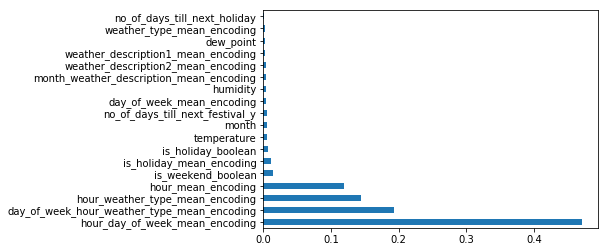

In [469]:
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
model = ExtraTreesRegressor()
model.fit(train[features],train['traffic_volume'])
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=features)
feat_importances.nlargest(30).plot(kind='barh')
plt.show()

In [474]:
from deap import base, creator
import random
import numpy as np
from deap import tools
#import FeatureFitness as ff

import logging
logging.basicConfig(filename='gm_model.log',level=logging.DEBUG)

class FeatureSelectionGA:
   

    def __init__(self, model, x, y, cv_split=5, verbose=0):
       
        self.model = model
        self.n_features = x.shape[1]
        self.toolbox = None
        self.creator = self._create()
        self.cv_split = cv_split
        self.x = x.values
        self.y = y.values
        self.verbose = verbose
        if self.verbose == 1:
            print("Model {} will select best features among {} features using cv_split :{}.".format(model, x.shape[1],
                                                                                                    cv_split))
            print("Shape od train_x: {} and target: {}".format(x.shape, y.shape))
        self.final_fitness = []
        self.fitness_in_generation = {}
        self.best_ind = None

    def evaluate(self, individual):
         
        fit_obj = FitenessFunction(self.cv_split)
        np_ind = np.asarray(individual)
        if np.sum(np_ind) == 0:
            fitness = 0.0
        else:
            feature_idx = np.where(np_ind == 1)[0]
            fitness = fit_obj.calculate_fitness(self.model, self.x[:, feature_idx], self.y)

        if self.verbose == 1:
            print("Individual: {}  Fitness_score: {} ".format(individual, fitness))

        return fitness,

    def _create(self):
        creator.create("FeatureSelect", base.Fitness, weights=(1.0,))
        creator.create("Individual", list, fitness=creator.FeatureSelect)
        return creator

    def create_toolbox(self):
    
        self._init_toolbox()
        return toolbox

    def register_toolbox(self, toolbox):
     
        toolbox.register("evaluate", self.evaluate)
        self.toolbox = toolbox

    def _init_toolbox(self):
        toolbox = base.Toolbox()
        toolbox.register("attr_bool", random.randint, 0, 1)
        # Structure initializers
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, self.n_features)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        return toolbox

    def _default_toolbox(self):
        toolbox = self._init_toolbox()
        toolbox.register("mate", tools.cxTwoPoint)
        toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
        toolbox.register("select", tools.selTournament, tournsize=3)
        toolbox.register("evaluate", self.evaluate)
        return toolbox

    def get_final_scores(self, pop, fits):
        self.final_fitness = list(zip(pop, fits))

    def generate(self, n_pop, cxpb=0.5, mutxpb=0.2, ngen=5, set_toolbox=False):

       

        if self.verbose == 1:
            print(
                "Population: {}, crossover_probablity: {}, mutation_probablity: {}, total generations: {}".format(n_pop,
                                                                                                                  cxpb,
                                                                                                                  mutxpb,
                                                                                                                            ngen))
            logging.debug(
                "Population: {}, crossover_probablity: {}, mutation_probablity: {}, total generations: {}".format(n_pop,
                                                                                                                  cxpb,
                                                                                                                  mutxpb,
                                                                                                                  ngen))

        if not set_toolbox:
            self.toolbox = self._default_toolbox()
        else:
            raise Exception(
                "Please create a toolbox.Use create_toolbox to create and register_toolbox to register. Else set set_toolbox = False to use defualt toolbox")
        pop = self.toolbox.population(n_pop)
        CXPB, MUTPB, NGEN = cxpb, mutxpb, ngen

        # Evaluate the entire population
        print("EVOLVING.......")
        logging.debug("EVOLVING.......")
        fitnesses = list(map(self.toolbox.evaluate, pop))

        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

        for g in range(NGEN):
            print("-- GENERATION {} --".format(g + 1))
            logging.debug("-- GENERATION {} --".format(g + 1))
            offspring = self.toolbox.select(pop, len(pop))
            self.fitness_in_generation[str(g + 1)] = max([ind.fitness.values[0] for ind in pop])
            # Clone the selected individuals
            offspring = list(map(self.toolbox.clone, offspring))

            # Apply crossover and mutation on the offspring
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < CXPB:
                    self.toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values

            for mutant in offspring:
                if random.random() < MUTPB:
                    self.toolbox.mutate(mutant)
                    del mutant.fitness.values

            # Evaluate the individuals with an invalid fitness
            weak_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = list(map(self.toolbox.evaluate, weak_ind))
            for ind, fit in zip(weak_ind, fitnesses):
                ind.fitness.values = fit
            print("Evaluated %i individuals" % len(weak_ind))
            logging.debug("Evaluated %i individuals" % len(weak_ind))

            # The population is entirely replaced by the offspring
            pop[:] = offspring

            # Gather all the fitnesses in one list and print the stats
        fits = [ind.fitness.values[0] for ind in pop]

        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x * x for x in fits)
        std = abs(sum2 / length - mean ** 2) ** 0.5
        if self.verbose == 1:
            print("  Min %s" % min(fits))
            print("  Max %s" % max(fits))
            print("  Avg %s" % mean)
            print("  Std %s" % std)

        print("-- Only the fittest survives --")
        logging.debug("-- Only the fittest survives --")

        self.best_ind = tools.selBest(pop, 1)[0]
        print("Best individual is %s, %s" % (self.best_ind, self.best_ind.fitness.values))
        logging.debug("Best individual is %s, %s" % (self.best_ind, self.best_ind.fitness.values))
        self.get_final_scores(pop, fits)

        return pop,self.best_ind



from sklearn.model_selection import StratifiedKFold
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 
import logging


class FitenessFunction:

    def __init__(self, n_splits=5, *args, **kwargs):
        self.n_splits = n_splits

    def calculate_fitness(self, model, x, y):
        cv_set = np.repeat(-1., x.shape[0])
        skf = StratifiedKFold(n_splits=self.n_splits)
        for train_index, test_index in skf.split(x, y):
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]
            if x_train.shape[0] != y_train.shape[0]:
                raise Exception()
            model.fit(x_train, y_train)
            predicted_y = model.predict(x_test)
            cv_set[test_index] = predicted_y
        r=mean_squared_error(y,cv_set)
        return -r




In [475]:
def geneticFeatureSeelction(model,train,features,target,n_pop,ngen):
        x_train,y_train=train[features],train[target]
        fsga = FeatureSelectionGA(model, x_train, y_train)
        pop ,best_ind= fsga.generate(n_pop=n_pop, ngen=ngen)
        po = best_ind
        genetic_features=[]
        listb=features
        for i in range(len(po)):
            if po[i] == 1 :
                genetic_features.append(listb[i])

        print(genetic_features)
        
        return genetic_features

In [478]:
model=RandomForestRegressor(n_estimators=200,max_depth=12,max_features=0.8)
x=geneticFeatureSeelction(model,train,features,"traffic_volume",8,10)

EVOLVING.......
-- GENERATION 1 --
Evaluated 5 individuals
-- GENERATION 2 --
Evaluated 2 individuals
-- GENERATION 3 --
Evaluated 6 individuals
-- GENERATION 4 --
Evaluated 4 individuals
-- GENERATION 5 --
Evaluated 6 individuals
-- GENERATION 6 --
Evaluated 6 individuals
-- GENERATION 7 --
Evaluated 6 individuals
-- GENERATION 8 --
Evaluated 6 individuals
-- GENERATION 9 --
Evaluated 7 individuals
-- GENERATION 10 --
Evaluated 6 individuals
-- Only the fittest survives --
Best individual is [1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1], (-156394.8587616937,)
['hour_mean_encoding', 'temperature', 'is_weekend_boolean', 'is_holiday_boolean', 'day_of_week_hour_weather_type_mean_encoding', 'is_holiday_mean_encoding', 'month', 'hour_day_of_week_mean_encoding', 'weather_type_mean_encoding', 'hour_weather_type_mean_encoding', 'no_of_days_till_next_holiday', 'no_of_days_till_next_festival_y', 'weather_description2_mean_encoding']


# Features Used

In [402]:
#train.columns

In [479]:
features=[
          'hour_mean_encoding',
          'temperature',
          #'wind_direction',
          'wind_speed',
          'humidity',
          #'visibility_in_miles',
          'dew_point',
          'is_weekend_boolean',
          'is_holiday_boolean',
          'day_of_week_hour_weather_type_mean_encoding',
          'is_holiday_mean_encoding',
          'month',
          'month_weather_description_mean_encoding',
          'hour_day_of_week_mean_encoding',
          
          'weather_type_mean_encoding',
          #'day_of_week_hour_mean_encoding',
          'day_of_week_mean_encoding',
          'hour_weather_type_mean_encoding','no_of_days_till_next_holiday',
          'no_of_days_till_next_festival_y',
          #'holidays'
           'weather_description1_mean_encoding',
           'weather_description2_mean_encoding',
           'rain_p_h1',
           'rain_p_h2',
           'snow_p_h' 
           #'rain_snow'
           #'weather_type1_mean_encoding',
           #'weather_type2_mean_encoding' 
          
          
         ]

final_features=features

# XG boost

In [453]:
import xgboost
best_xgb_model = xgboost.XGBRegressor(colsample_bytree=0.5,
                 gamma=1,                 
                 learning_rate=0.04,
                 max_depth=6,
                 n_estimators=250,                                                                    
                 seed=0)
best_xgb_model.fit(train[final_features],train["traffic_volume"])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=1, learning_rate=0.04, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=250,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=1)

In [465]:
import math
from sklearn.metrics import mean_squared_error,mean_squared_log_error

pred_val_xgb=best_xgb_model.predict(train[final_features])
print(math.sqrt(mean_squared_error(train['traffic_volume'],pred_val_xgb)))
#print(math.sqrt(mean_squared_log_error(train['traffic_volume'],pred_val_xgb)))



333.9359191618962


In [450]:
#np.where(pred_val_xgb<=0)

# Random Forest 

In [451]:
np.where(np.isnan(np.log(train['traffic_volume']))==True)

(array([], dtype=int64),)

In [408]:
import math
from sklearn.ensemble import RandomForestRegressor
model_reg=RandomForestRegressor(n_estimators=350,max_depth=12,max_features=0.8)
model_reg.fit(train[final_features],train['traffic_volume'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features=0.8, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=350, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [409]:
#model_reg.predict(test[final_features])

In [410]:
import math
from sklearn.metrics import mean_squared_error,mean_squared_log_error
pred_val_reg=model_reg.predict(train[final_features])
print(math.sqrt(mean_squared_error(train['traffic_volume'],pred_val_reg)))
print(math.sqrt(mean_squared_log_error(train['traffic_volume'],pred_val_reg)))


300.07409553612666
0.24387598071905234


# Light gbm

In [455]:
import lightgbm as lgbm
model_lgb = lgbm.LGBMRegressor(max_depth=12,n_estimator=1000,learning_rate=0.1,colsample_bytree=0.867)

In [456]:
model_lgb.fit(train[final_features],train['traffic_volume'])

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.867,
       importance_type='split', learning_rate=0.1, max_depth=12,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimator=1000, n_estimators=100, n_jobs=-1, num_leaves=31,
       objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
       silent=True, subsample=1.0, subsample_for_bin=200000,
       subsample_freq=0)

In [457]:
train.iloc[900][['traffic_volume','predicted_rf','predicted_lgb','predicted_xgb']]

traffic_volume        223
predicted_rf      368.849
predicted_lgb     368.117
predicted_xgb     373.125
Name: 900, dtype: object

In [458]:
np.where(pred_val_lgb<0)

(array([25185], dtype=int64),)

In [464]:
pred_val_lgb=model_lgb.predict(train[final_features])

print(math.sqrt(mean_squared_error(train['traffic_volume'],pred_val_lgb)))
#print(math.sqrt(mean_squared_log_error(train['traffic_volume'],pred_val_lgb)))


327.2650946523795


In [460]:
train['predicted_rf']=pred_val_reg
train['predicted_lgb']=pred_val_lgb
train['predicted_xgb']=pred_val_xgb
train['final_two']=(train["predicted_rf"]+train["predicted_lgb"])/2
train['final_three']=(train["predicted_rf"]+train["predicted_lgb"]+train['predicted_xgb'])/3

In [461]:
#validation with hour_weather_mean_encoding

print(math.sqrt(mean_squared_error(train['traffic_volume'],train['day_of_week_hour_weather_type_mean_encoding'])))
#print(math.sqrt(mean_squared_log_error(train['traffic_volume'],train['day_of_week_hour_weather_type_mean_encoding'])))


529.1555611971464


In [462]:
#validation with ensemble lgm,rf

print(math.sqrt(mean_squared_error(train['traffic_volume'],train['final_two'])))
#print(math.sqrt(mean_squared_log_error(train['traffic_volume'],train['final_two'])))


306.88813085915916


In [463]:
#validation with ensemble lgm,rf
#305,314
print(math.sqrt(mean_squared_error(train['traffic_volume'],train['final_three'])))
#print(math.sqrt(mean_squared_log_error(train['traffic_volume'],train['final_three'])))


313.9298362449557


# Prediction On Test

In [425]:
test['date_time2'] = pd.to_datetime(test['date_time2'])

In [426]:
test=test.drop_duplicates("date_time2")


In [427]:
#train.isnull().sum()

In [428]:
prediction_rgb=model_reg.predict(test[final_features])
prediction_lgb=model_lgb.predict(test[final_features])
predicted_xgb=best_xgb_model.predict(test[final_features])

# Ensembling on Test

In [438]:
test['predicted_rf']=prediction_rgb
test['predicted_lgb']=prediction_lgb
test['predicted_xgb']=predicted_xgb
test['traffic_volume']=(test["predicted_rf"]+test["predicted_lgb"]+test['predicted_xgb'])/3
#test['traffic_volume']=prediction_rgb
#test['traffic_volume']=(test["predicted_rf"]+test["predicted_lgb"])/2

In [439]:
test[['date_time','traffic_volume']].to_csv('regg.csv')

In [440]:
def create_time_features(data):
    data['date_time_new'] = pd.to_datetime(data['date_time'])
    data['date'] = pd.to_datetime(data['date_time_new'].dt.date)
    data['year'] = data['date_time_new'].dt.year
    data['time'] = data['date_time_new'].dt.time
    data['hours'] = data['time'].apply(lambda x: str(x).split(':')[0]).astype(int)
    data['day_month'] = data['date_time_new'].dt.day
    data['day_week'] = data['date_time_new'].dt.dayofweek
    data['month'] = data['date_time_new'].dt.month
    return data


In [441]:
def create_time_features2(data):
    data['date_time_new'] = pd.to_datetime(data['date_time2'])
    data['date'] = pd.to_datetime(data['date_time_new'].dt.date)
    data['year'] = data['date_time_new'].dt.year
    data['time'] = data['date_time_new'].dt.time
    data['hours'] = data['time'].apply(lambda x: str(x).split(':')[0]).astype(int)
    data['day_month'] = data['date_time_new'].dt.day
    data['day_week'] = data['date_time_new'].dt.dayofweek
    data['month'] = data['date_time_new'].dt.month
    return data

In [442]:
test.reset_index(inplace=True,drop=True)

In [443]:
subm = pd.read_csv(r"E:\Spark\DataSets\Test.csv")

subm = create_time_features(subm)

In [444]:

subm = subm[['date_time','date','hours']]

test = create_time_features2(test)

pred = test

In [445]:

pred['date'] = pd.to_datetime(pred['date'])


subm = subm.merge(pred[['date','hours','traffic_volume']],how='left',left_on=['date','hours'],
                                    right_on=['date','hours'])
subm['traffic_volume'] = np.where(subm['traffic_volume']<=0,20,subm['traffic_volume'])



In [446]:
subm[['date_time','traffic_volume']].to_csv('next_reg_503.csv',index=False)


In [211]:
subm.shape

(14454, 4)